<a href="https://colab.research.google.com/github/tcharos/NLP-Toxicity-Detection/blob/main/AIDL_CS01_NLP_Project_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIDL_B_CS01: Advanced NLP Project

## BERT-alike STS-b Semantic Similarity (PyTorch/HF)

In [ ]:
import os
import sys

IN_COLAB = 'google.colab' in sys.modules
BASE_DIR = "/content" if IN_COLAB else "."
TOXICITY_PATH = os.path.join(BASE_DIR, "data_sets/toxicity")

if IN_COLAB:
    print("Running in Google Colab. Installing NLP stack...")
    !pip install -q -U transformers datasets accelerate peft trl sentence-transformers
else:
    print("Running locally. Checking Mac-specific requirements...")
    !{sys.executable} -m pip install -q "tensorflow==2.16.2" "tensorflow-macos==2.16.2" "tf-keras~=2.16"
    !{sys.executable} -m pip install -q -U transformers datasets accelerate peft trl sentence-transformers

os.environ["KERAS_BACKEND"] = "tensorflow"

import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import f1_score, confusion_matrix

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments
)

from peft import LoraConfig, get_peft_model
from trl import DPOTrainer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


print(f"\nTensorFlow Version: {tf.__version__}")
print("Num GPUs Available (TF): ", len(tf.config.list_physical_devices('GPU')))

HAS_MPS = torch.backends.mps.is_available()
HAS_CUDA = torch.cuda.is_available()

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("PyTorch Device: Mac GPU (Metal)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch Device: Colab GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("PyTorch Device: CPU")

### Functions

In [48]:
def load_with_encoding(filename):
    try:
        return pd.read_csv(filename, encoding='utf-8')
    except UnicodeDecodeError:
        print(f"UTF-8 failed for {filename}, falling back to latin1")
        return pd.read_csv(filename, encoding='latin1')

def evaluate_stsb(y_true, y_pred, model_name="BERT Model"):

    pearson_val, _ = pearsonr(y_true, y_pred)
    spearman_val, _ = spearmanr(y_true, y_pred)

    y_true_int = np.rint(y_true).astype(int)
    y_pred_int = np.clip(np.rint(y_pred), 0, 5).astype(int)
    cm = confusion_matrix(y_true_int, y_pred_int)

    print(f"\n--- STS-b Regression: {model_name} ---")
    print(f"Pearson Correlation:  {pearson_val:.4f}")
    print(f"Spearman Correlation: {spearman_val:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'STS-b Confusion Matrix\n{model_name}')
    plt.ylabel('Actual (Rounded)')
    plt.xlabel('Predicted (Rounded)')
    plt.show()

    return pearson_val, spearman_val

## 2. Semantic Similarity (STS-b) with BERT-alike Models (PyTorch/HF)

In [ ]:
raw_datasets = load_dataset("mteb/stsbenchmark-sts")

Platform	HAS_CUDA	Precision Used

Local Mac (MPS)	False	FP32 (Standard)

Colab (T4 GPU)	True	FP16 (Mixed)

Colab (A100/L4 GPU)	True	BF16 (Mixed/Stable)

In [29]:
def preprocess_sts(examples, tokenizer):
    # STS-b expects two sentences and a float label
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

def train_transformer(base_config, model_id, label_name):
    print(f"\n--- Training {label_name} ({model_id}) ---")

    tokenizer = AutoTokenizer.from_pretrained(model_id)

    tokenized_datasets = raw_datasets.map(lambda x: preprocess_sts(x, tokenizer), batched=True)
    tokenized_datasets = tokenized_datasets.rename_column("score", "labels")

    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=1)

    training_args = TrainingArguments(
        output_dir=f"./results_{label_name.lower()}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=base_config.get('learning_rate'),
        per_device_train_batch_size=base_config.get('per_device_train_batch_size'),
        num_train_epochs=base_config.get('num_train_epochs'),
        weight_decay=base_config.get('weight_decay'),
        load_best_model_at_end=True,
        remove_unused_columns=True,
        fp16=HAS_CUDA and not torch.cuda.is_bf16_supported(),
        bf16=HAS_CUDA and torch.cuda.is_bf16_supported(),
        max_grad_norm=1.0,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
    )

    trainer.train()

    return trainer, tokenized_datasets["validation"]

In [30]:
BASE_CONFIG = {
    "eval_strategy": "epoch",
    "save_strategy": "epoch",
    "learning_rate": 2e-5,
    "per_device_train_batch_size": 16,
    "num_train_epochs": 3,
    "weight_decay": 0.01,
    "load_best_model_at_end": True,
    "remove_unused_columns": True,
    "report_to": "none",
    "fp16": HAS_CUDA and not torch.cuda.is_bf16_supported(),
    "bf16": HAS_CUDA and torch.cuda.is_bf16_supported(),
}

### BERT

In [31]:
CONFIG_BERT = BASE_CONFIG.copy()

In [45]:
print("--- BERT-Base Model Configuration ---")
pprint(CONFIG_BERT, sort_dicts=False)

--- BERT-Base Model Configuration ---
{'eval_strategy': 'epoch',
 'save_strategy': 'epoch',
 'learning_rate': 2e-05,
 'per_device_train_batch_size': 16,
 'num_train_epochs': 3,
 'weight_decay': 0.01,
 'load_best_model_at_end': True,
 'remove_unused_columns': True,
 'report_to': 'none',
 'fp16': False,
 'bf16': True}


In [ ]:
trainer_bert, val_data_bert = train_transformer(CONFIG_BERT, "bert-base-uncased", "BERT")

In [33]:
bert_results = trainer_bert.predict(val_data_bert)
preds_bert = bert_results.predictions.flatten()
true_labels_bert = np.array(val_data_bert["labels"])

print("--- BERT Prediction Analysis ---")
print("First 10 predictions: ", preds_bert[:10])
print("Unique predictions:   ", len(np.unique(preds_bert)))
print("Std Deviation:        ", np.std(preds_bert))

print("\n--- Label Analysis ---")
print("First 10 true labels: ", true_labels_bert[:10])

--- BERT Prediction Analysis ---
First 10 predictions:  [4.875    4.5625   4.8125   2.03125  2.640625 2.765625 4.90625  2.046875
 4.75     4.78125 ]
Unique predictions:    516
Std Deviation:         1.4861807

--- Label Analysis ---
First 10 true labels:  [5.    4.75  5.    2.4   2.75  2.615 5.    2.333 3.75  5.   ]



--- STS-b Regression: BERT-Base ---
Pearson Correlation:  0.8894
Spearman Correlation: 0.8850


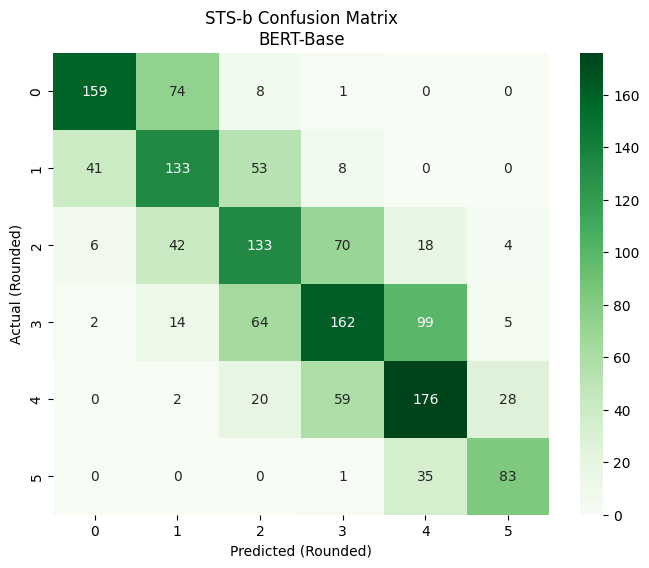

In [49]:
pearson_bert, spearman_bert = evaluate_stsb(true_labels_bert, preds_bert, model_name="BERT-Base")

### RoBERTa

In [35]:
CONFIG_ROBERTA = BASE_CONFIG.copy()
CONFIG_ROBERTA['learning_rate'] = 3e-5
CONFIG_ROBERTA['per_device_train_batch_size'] = 32

In [46]:
print("--- RoBERTa-Base Model Configuration ---")
pprint(CONFIG_ROBERTA, sort_dicts=False)

--- RoBERTa-Base Model Configuration ---
{'eval_strategy': 'epoch',
 'save_strategy': 'epoch',
 'learning_rate': 3e-05,
 'per_device_train_batch_size': 32,
 'num_train_epochs': 3,
 'weight_decay': 0.01,
 'load_best_model_at_end': True,
 'remove_unused_columns': True,
 'report_to': 'none',
 'fp16': False,
 'bf16': True}


In [ ]:
trainer_roberta, val_data_roberta = train_transformer(CONFIG_ROBERTA, "roberta-base", "RoBERTa")

In [ ]:
roberta_results = trainer_roberta.predict(val_data_roberta)
preds_roberta = roberta_results.predictions.flatten()
true_labels_roberta = np.array(val_data_roberta["labels"])

print("--- RoBERTa Prediction Analysis ---")
print("First 10 predictions: ", preds_roberta[:10])
print("Unique predictions:   ", len(np.unique(preds_roberta)))
print("Std Deviation:        ", np.std(preds_roberta))

print("\n--- Label Analysis ---")
print("First 10 true labels: ", true_labels_roberta[:10])


--- STS-b Regression: RoBERTa-Base ---
Pearson Correlation:  0.9057
Spearman Correlation: 0.9029


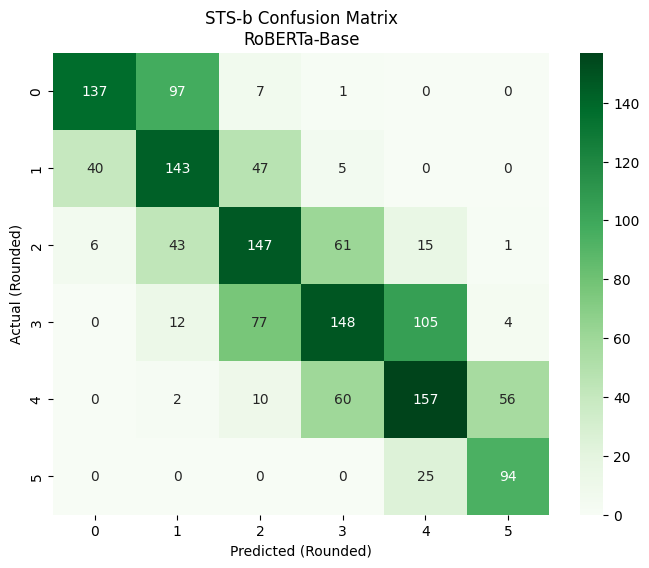

In [50]:
pearson_roberta, spearman_roberta = evaluate_stsb(true_labels_roberta, preds_roberta, model_name="RoBERTa-Base")

### DeBERTaV3

In [38]:
CONFIG_DEBERTA = BASE_CONFIG.copy()
CONFIG_DEBERTA['learning_rate'] = 1e-5

In [47]:
print("--- DeBERTaV3-Base Model Configuration ---")
pprint(CONFIG_DEBERTA, sort_dicts=False)

--- DeBERTaV3-Base Model Configuration ---
{'eval_strategy': 'epoch',
 'save_strategy': 'epoch',
 'learning_rate': 1e-05,
 'per_device_train_batch_size': 16,
 'num_train_epochs': 3,
 'weight_decay': 0.01,
 'load_best_model_at_end': True,
 'remove_unused_columns': True,
 'report_to': 'none',
 'fp16': False,
 'bf16': True}


In [39]:
trainer_deberta, val_data_deberta = train_transformer(CONFIG_DEBERTA, "microsoft/deberta-v3-base", "DeBERTaV3")


--- Training DeBERTaV3 (microsoft/deberta-v3-base) ---


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/5749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1379 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.449853
2,0.935800,0.435708
3,0.274600,0.438017


In [40]:
deberta_results = trainer_deberta.predict(val_data_deberta)
preds_deberta = deberta_results.predictions.flatten()
true_labels_deberta = np.array(val_data_deberta["labels"])

print("--- DeBERTaV3 Prediction Analysis ---")
print("First 10 predictions: ", preds_deberta[:10])
print("Unique predictions:   ", len(np.unique(preds_deberta)))
print("Std Deviation:        ", np.std(preds_deberta))

print("\n--- Label Analysis ---")
print("First 10 true labels: ", true_labels_deberta[:10])

--- DeBERTaV3 Prediction Analysis ---
First 10 predictions:  [5.09375  4.875    4.84375  2.296875 2.53125  2.5      5.0625   3.3125
 4.71875  5.      ]
Unique predictions:    515
Std Deviation:         1.5209831

--- Label Analysis ---
First 10 true labels:  [5.    4.75  5.    2.4   2.75  2.615 5.    2.333 3.75  5.   ]



--- STS-b Regression: DeBERTaV3-Base ---
Pearson Correlation:  0.9057
Spearman Correlation: 0.9085


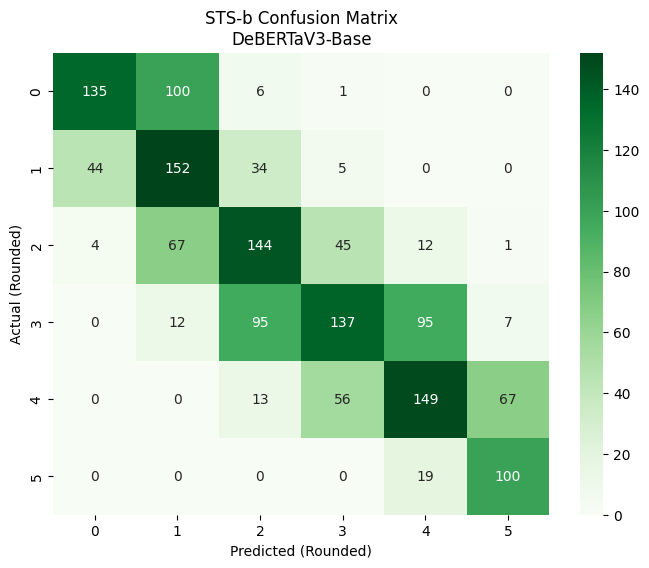

In [51]:
pearson_deberta, spearman_deberta = evaluate_stsb(true_labels_deberta, preds_deberta, model_name="DeBERTaV3-Base")

### RoBERTa-Base vs DeBERTaV3-Base Comparison

In [42]:
comparison_data = {
    "Model": ["BERT-Base", "RoBERTa-Base", "DeBERTaV3-Base"],
    "Pearson Correlation": [pearson_bert, pearson_roberta, pearson_deberta],
    "Spearman Correlation": [spearman_bert, spearman_roberta, spearman_deberta]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n--- BERT-Base vs RoBERTa-Base vs DeBERTaV3-Base Comparison ---")
print(comparison_df)


--- BERT-Base vs RoBERTa-Base vs DeBERTaV3-Base Comparison ---
            Model  Pearson Correlation  Spearman Correlation
0       BERT-Base             0.889428              0.885034
1    RoBERTa-Base             0.914331              0.912891
2  DeBERTaV3-Base             0.905655              0.908510
